## Assumptions
* space_dependent - these are cast to functions, not commutative

* momentum_symbols - will be specified (default to kx, ky, kz probably) and not commutative

* constant - commutative, everything else

* coordinates are always create as symbol with commutative=False

* lattice constant is always a

In [1]:
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

from discretizer import coord, a
from discretizer import substitute_functions, derivate

## Defining input expression

In [2]:
A, B, C, D = sympy.symbols('A B C D', commutative=False)
space_dependent = ['A', 'B']

In [3]:
expr = B*C*A + D; expr

B⋅C⋅A + D

## Substituting functions

In [4]:
expr = substitute_functions(expr, space_dependent); expr

D + B(x, y, z)⋅C⋅A(x, y, z)

## Calculation derivation

In [5]:
expr

D + B(x, y, z)⋅C⋅A(x, y, z)

In [99]:
derivate(expr, (1, 0, 0))

0

# Walking sympy tree

In [100]:
from sympy.printing.dot import dotprint
from graphviz import Source
graph = lambda x: Source(dotprint(x))

In [101]:
kx, ky, kz = sympy.symbols('k_x k_y k_z', commutative=False)
Psi = sympy.Symbol('Psi', commutative=False) #sympy.Function('Psi')(*coord)


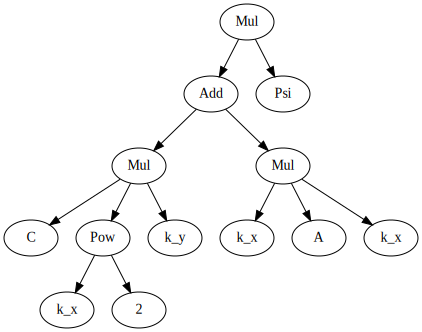

In [102]:
expr = kx*A*kx + C * kx**2 * ky
expr = expr * Psi
graph(expr)

In [103]:
expr = sympy.expand(expr); expr

    2                  
C⋅kₓ ⋅k_y⋅Ψ + kₓ⋅A⋅kₓ⋅Ψ

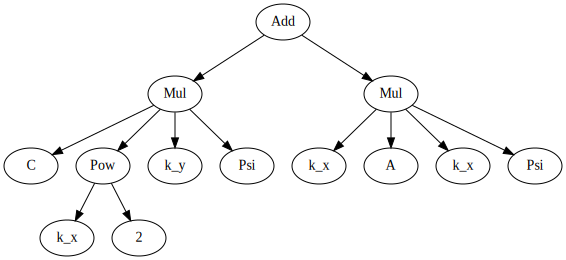

In [104]:
graph(expr)

In [105]:
momentum_operators = [kx, ky, kz]


for subexpr in expr.args:
    print("Testing: '{}'".format(subexpr))
    for arg in subexpr.args[::-1]:
        if arg in momentum_operators:
            print('\t', arg, True)

        elif arg.func == sympy.Pow and arg.args[0] in momentum_operators:
                print('\t', arg, True)
        else:
            print('\t', arg, False)
        
    print()

Testing: 'C*k_x**2*k_y*Psi'
	 Psi False
	 k_y True
	 k_x**2 True
	 C False

Testing: 'k_x*A*k_x*Psi'
	 Psi False
	 k_x True
	 A False
	 k_x True



# Generalizing

In [124]:
def split_factors(expr):
    """ Split symbolic expression for a discretization step.
    
    Parameters:
    -----------
    expr : sympy expression
        symbolic expression to be split
        
    Output:
    -------
    lhs : sympy expression
        part of expression standing to the left from operators 
        that acts in current discretization step
    
    operators: sympy expression
        operators that perform discretization in current step
    
    rhs : sympy expression
        part of expression that is derivated in current step
    
    """
    assert isinstance(expr, sympy.Mul), 'input expr is not sympy.Mul'
    output = {'rhs': [], 'operators': [], 'lhs': []}
    normal = True
    
    iterator = iter(expr.args[::-1])     
    for factor in iterator:
        if factor not in momentum_operators:
            output['rhs'].append(factor)
        else:
            output['operators'].append(factor)
            break
    
    for factor in iterator:
        if factor in momentum_operators:
            output['operators'].append(factor)
        else:
            output['lhs'].append(factor)
            break
    
    for factor in iterator:
        output['lhs'].append(factor)
    
    output = tuple(sympy.Mul(*output[key][::-1]) 
                   for key in ['lhs', 'operators', 'rhs'])
    return output

In [125]:
print(subexpr)

k_x*A*k_x*Psi


In [126]:
%timeit split_factors(subexpr)

1000 loops, best of 3: 137 µs per loop


In [127]:
split_factors(subexpr)

(kₓ⋅A, kₓ, Ψ)